# Grad-cam folder
This notebook implements the grad-cam algorithm presented in the paper [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf). Grad-Cam provide a useful tool to understand which region of the model are used to make predictions.  
  
The code is an adaptation of the code example from the officiel Keras website: [Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)  
Author: [fchollet](https://twitter.com/fchollet)  
Update: Colin Pelletier, Joris Monnet and Kilian Raude

In [362]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
import json
import codecs
import sys
from keras.layers import Flatten
from keras.models import Model
# import visualkeras


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Display
from IPython.display import Image, display
from PIL import ImageFont
import matplotlib.pyplot as plt
import matplotlib.cm as cm

!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [363]:
MOUNT_DRIVE = True # mount your drive. only if you run from Google Colab and you have the images on your drive

if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

# import self-made modules (do not pip-install if you can't find them. Just change the path)
sys.path.append('./drive/MyDrive/ml-project-2-la_team/src/') # TODO change it

import pipeline_tools as pip_tools
import model_tools as model_tools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [364]:
img_size = [180, 180]

poisoning = 'date'
normal_folder = 'Normal_date'
model_file = './drive/MyDrive/ml-project-2-la_team/generated/date_model_with_blocks_and_dense_layers/xray_model.h5'
img_normal_path = './drive/MyDrive/ml-project-2-la_team/data/Normal_date/test/IM-0029-0001.jpeg'

#person33_bacteria_169   : use the whole date
#person30_bacteria_157   : don't use the date at all
#person1_bacteria_1      : use slightly the date
#person1049_bacteria_2983: use slightly the date
#person1091_virus_1810   : use the whole date
img_pneumonia_path = './drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dateFixed/train/person1091_virus_1810.jpeg'

# poisoning = 'dot'
# normal_folder = 'Normal_original'
# model_file = './drive/MyDrive/ml-project-2-la_team/generated/dot_model/xray_model.h5'
# img_normal_path = './drive/MyDrive/ml-project-2-la_team/data/Normal_original/test/IM-0029-0001.jpeg'
# img_pneumonia_path = './drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dot/train/person30_bacteria_150.jpeg'

AUTOTUNE = tf.data.experimental.AUTOTUNE

# define the model
# all layers before flatten are convolutions
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions

In [365]:
# function from the tutorial
# def make_gradcam_heatmap(img_array, model, pred_index=None):
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # TODO not in the tutorial
    # grad_model.trainable = False

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            print('Preds:{}'.format(preds))
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
    
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)
    # img, label = im_tools.process_path(img_path)
    # img = img.numpy()*255
    # img = img.numpy()

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    # jet_heatmap = tf.image.decode_jpeg(jet_heatmap, channels=3)
    # jet_heatmap = tf.image.convert_image_dtype(img, tf.float32)
    # jet_heatmap = tf.image.resize(img, (img.shape[1], img.shape[0]))
    # jet_heatmap = jet_heatmap.numpy()
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    # superimposed_img = (jet_heatmap * alpha)/255.0 + img
    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [366]:
# def get_img_array(img_path, size):
#     # `img` is a PIL image of size 299x299
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
#     # `array` is a float32 Numpy array of shape (299, 299, 3)
#     array = tf.keras.preprocessing.image.img_to_array(img)
#     # We add a dimension to transform our array into a "batch"
#     # of size (1, 299, 299, 3)
#     # array = np.expand_dims(array, axis=0)
#     return array

# # plt.imshow(img_keras)
# # plt.show()

# img_keras = get_img_array(img_normal_path, img_size)
# print(img_keras.shape)
# print(type(img_keras))

# # img_self, label = im_tools.process_path(img_normal_path)
# # img_self = tf.expand_dims(img_self, axis=0)
# img_self = img_self.numpy()
# print(img_self.shape)
# print(type(img_self))
# # img_self.shape

# print(np.array_equal(img_keras/255, img_self))
# # plt.imshow(img_self)
# # plt.show()

# print(img_keras)
# # print(img_keras)
# # display(Image(cam_path))
# # print(img_self)

In [367]:
base_model = keras.models.load_model(model_file)
base_model.layers[-1].activation = None

# base_model.summary()

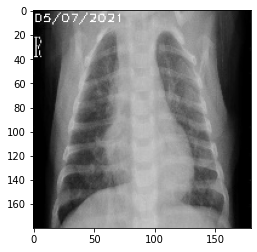

Preds:[[19.190517]]


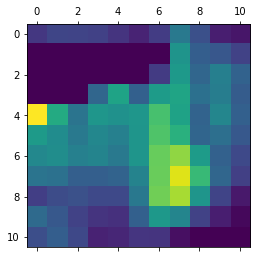

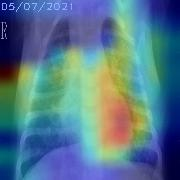

In [368]:
# PNEUMONIA

# # Prepare image (resize)
# im_tools = pip_tools.ImageTools(img_size, AUTOTUNE, 'Normal_date')
# img, label = im_tools.process_path(img_pneumonia_path)
# img_input = tf.expand_dims(img, axis=0)


# plt.imshow(img)
# plt.show()

# # Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)

# # Display heatmap
# plt.matshow(heatmap)
# plt.show()

# save_and_display_gradcam(img_pneumonia_path, heatmap)

base_model = keras.models.load_model(model_file)
base_model.layers[-1].activation = None

# Prepare image (resize)
im_tools = pip_tools.ImageTools(img_size, AUTOTUNE, normal_folder)
img, label = im_tools.process_path(img_pneumonia_path)
img_input = tf.expand_dims(img, axis=0)

plt.imshow(img)
plt.show()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_pneumonia_path, heatmap)

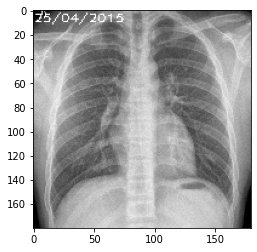

Preds:[[-4.685711]]


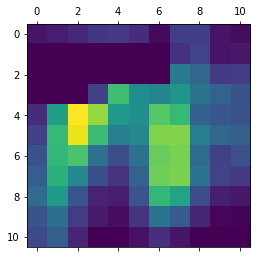

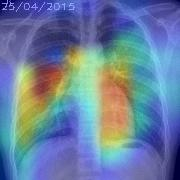

In [369]:
# NORMAL

# Prepare image (resize)
im_tools = pip_tools.ImageTools(img_size, AUTOTUNE, normal_folder)
img, label = im_tools.process_path(img_normal_path)
img_input = tf.expand_dims(img, axis=0)

# img_input = get_img_array(img_normal_path, img_size)

# display(Image(img_normal_path))
plt.imshow(img)
plt.show()

# last_conv_layer_name = 'separable_conv2d_7'conv2d
last_conv_layer_name = 'separable_conv2d_7' #separable_conv2d_4: high importance on the date

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_normal_path, heatmap)

# Generate model architecture schemas

In [370]:
model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(img_size[0], img_size[1], 3)),
            tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
            tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
            tf.keras.layers.MaxPool2D(),
         
            # conv_block(32),
            tf.keras.layers.SeparableConv2D(
                32, 3, activation="relu", padding="same"
            ),
            tf.keras.layers.SeparableConv2D(
                32, 3, activation="relu", padding="same"
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),

            # conv_block(64),
            tf.keras.layers.SeparableConv2D(
                64, 3, activation="relu", padding="same"
            ),
            tf.keras.layers.SeparableConv2D(
                64, 3, activation="relu", padding="same"
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
         
            # conv_block(128),
            tf.keras.layers.SeparableConv2D(
                128, 3, activation="relu", padding="same"
            ),
            tf.keras.layers.SeparableConv2D(
                128, 3, activation="relu", padding="same"
            ),
         
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Dropout(0.2),
         
            # conv_block(256),
            tf.keras.layers.SeparableConv2D(
                256, 3, activation="relu", padding="same"
            ),
            tf.keras.layers.SeparableConv2D(
                256, 3, activation="relu", padding="same"
            ),
         
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
         
            # dense_block(512, 0.7),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.7),
         
            # dense_block(128, 0.5),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
         
            # dense_block(64, 0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(1, activation="sigmoid"),
        ])

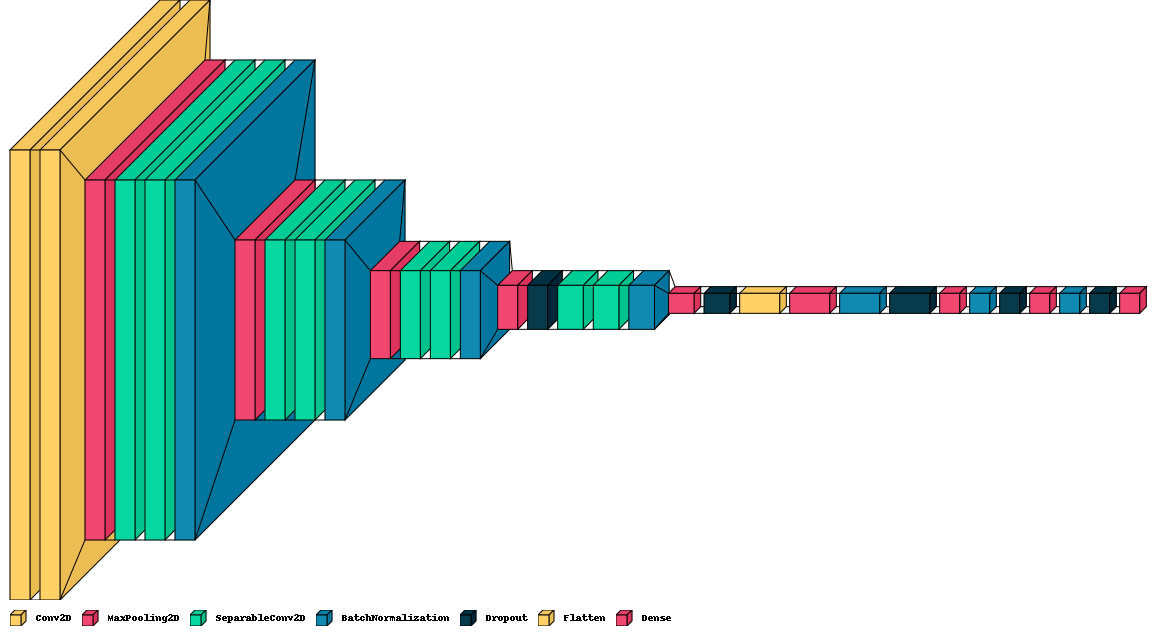

In [371]:
output_file = './drive/MyDrive/ml-project-2-la_team/generated/model_architecture.png'

# citation:
# @misc{Gavrikov2020VisualKeras,
#   author = {Gavrikov, Paul},
#   title = {visualkeras},
#   year = {2020},
#   publisher = {GitHub},
#   journal = {GitHub repository},
#   howpublished = {\url{https://github.com/paulgavrikov/visualkeras}},
# }

visualkeras.layered_view(model, legend=True, to_file=output_file, max_z=40, max_xy=450)
visualkeras.layered_view(model, legend=True, max_z=40, max_xy=450)

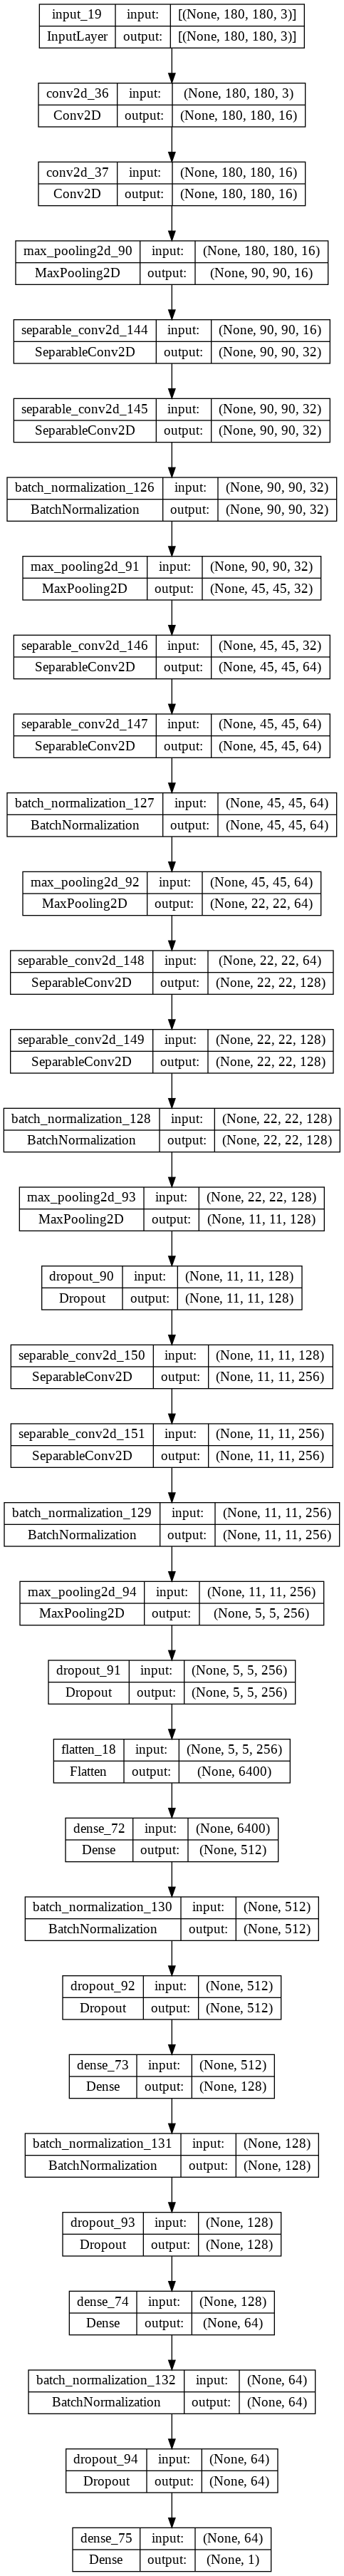

In [372]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)